### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Friday, Feb 19th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

### Solution

In [174]:
import numpy as np
from scipy import stats
from scipy import optimize
%matplotlib inline
import matplotlib.pyplot as plt
import corner

In [32]:
#1 
data= np.load('hw3_data_1.npy')
smean= np.sum(data[:,0])/100
print('sample mean is '+ str(smean))
svar= (np.sum((data[:,0]-smean)**2))/99 #N-1 because we used the sample mean to get here
sstd= np.sqrt(svar) #From earlier lessons
ssx= sstd/10
print('standard error on sample mean is '+ str(ssx)) 

sample mean is 3.937547512109005
standard error on sample mean is 0.11565177228177984


In [31]:
#2
def chi2(x,mu,sigma):
    chi2= np.sum(((x-mu)/sigma)**2)
    return chi2
#logL= -0.5*chi2(x,mu,sigma) + constant which we don't need
#we learned maximizing logL is just minimizing chi2 so let's do that
chi_squared = lambda mu: chi2(data[:,0],mu,data[:,1])
chi2min= optimize.fmin(chi_squared,smean)
print('MLE mean = '+str(chi2min))

Optimization terminated successfully.
         Current function value: 86.325091
         Iterations: 12
         Function evaluations: 24
MLE mean = [3.91803281]


Fisher uncertainty = 0.09481084100552237


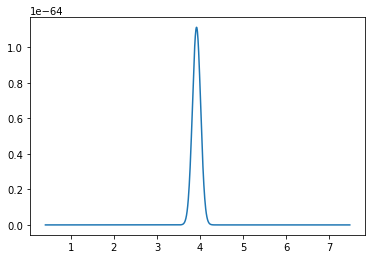

In [59]:
#3
#rewriting logL the same way we did in Lecture 5, by products of each Gaussian
xgrid= np.linspace(np.amin(data[:,0]),np.amax(data[:,0]),1000)
Ltot= 1
for i in range(len(data[:,0])):
    Ltot= Ltot*stats.norm.pdf(xgrid,loc=data[i,0],scale=data[i,1])
plt.plot(xgrid,Ltot)

#now we can calculate the Fisher matrix from here exactly as we did
sigma_mu = np.diff(np.log(Ltot[400:600]), n=2)
sigma_mu /= (xgrid[1]-xgrid[0])**2
sigma_mu *= -1
sigma_mu = 1/np.sqrt(sigma_mu)[0]
print('Fisher uncertainty = '+str(sigma_mu))
#So I had to restrict calculation to the middle part where the peak is, otherwise I got NaN.

In [118]:
#4
#I am going to resample each point knowing the mean and standard deviation and get 1000 different sets of draws
databoot= np.empty([1000,100])
for i in range(1000):
    for j in range(100):
        databoot[i,j]= stats.norm.rvs(data[j,0],data[j,1]) 
#each row is a new realization of 100 points

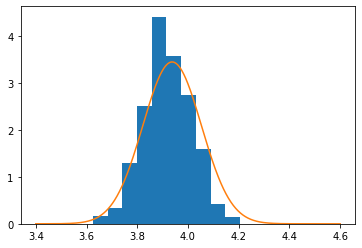

In [120]:
#5
#we learned maximizing logL is just minimizing chi2 so let's do that
smeans= np.empty(1000)
mlemeans= np.empty(1000)
for i in range(1000):
        smeans[i]= np.sum(databoot[i,:])/100
        chi_squared_boot = lambda mu: chi2(databoot[i,:],mu,data[:,1])
        chi2min_boot= optimize.fmin(chi_squared_boot,smeans[i],disp=False) #doing the same fitting for each realization
        mlemeans[i]= chi2min_boot
newxgrid=np.linspace(3.4,4.6,1000)
plt.hist(mlemeans,density=True)
plt.plot(newxgrid,stats.norm.pdf(newxgrid,3.9375,.11565))
plt.show()

#They definitely match-ish!


In [164]:
#6
#It looks really similar but we're minimizing a different thing

def laplace_loss(m,b,x):
    la_loss=np.sum(np.abs((x-m)/b))
    return la_loss
#logL= -laplace_loss + constant we don't need yet again   
laplace = lambda lap: laplace_loss(lap[0],lap[1],data[:,0])
lap= (smean,.1)
laplace_min= optimize.fmin(laplace,lap,xtol=4,ftol=4)
print(laplace_min)

#This was the smallest tolerance at which I could get everything to converge.

Optimization terminated successfully.
         Current function value: 6.268913
         Iterations: 23
         Function evaluations: 39
[ 3.7445154  14.66482422]


In [168]:
#7
#chi sq from the Gaussian fit was 86
AICGauss= 86+4+(12/97)
#L for Laplace was 6.27 but since it's not Gaussian I think the way to get something comparable to chi square, which
#for Gaussian dist is the first term of the AIC, would be to square it since it then would have the same form as chi sq
AICLaplace= 2*(6.27**2)+4+(12/97)

print(AICGauss,AICLaplace)
#So this says that Laplace is preferential but this is using my approximation for the first term of the AIC since I
#minimized the sum of residuals instead of maximizing the entire log likelihood expression, so it could totally be 
#too small.I also realize that we only fitted the Gaussian for the mean so if I had used 1 for my k value I would get a
# Gauss AIC of:

AICGauss1p= 86+2+(4/98)
print(AICGauss1p)

90.12371134020619 82.74951134020617
88.04081632653062


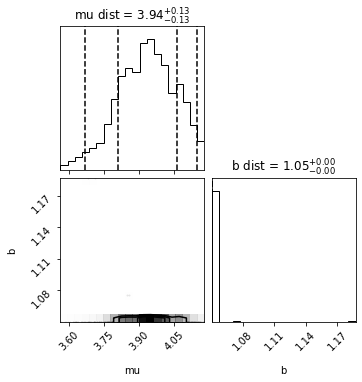

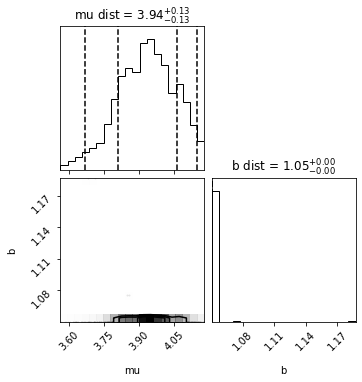

In [200]:
#8
mus= np.empty(1000)
bs= np.empty(1000)
for i in range(1000):
        laplace_boot = lambda lap: laplace_loss(lap[0],lap[1],data[:,0])
        lap=(smeans[i],1)
        laplacemin_boot= optimize.fmin(laplace_boot,lap,xtol=7,ftol=7,disp=False) #doing the same fitting for each realization
        mus[i]= laplacemin_boot[0]
        bs[i]= laplacemin_boot[1]
cornerdata=np.array([mus,bs])
corner.corner(cornerdata.T,labels=['mu','b'],titles=['mu dist','b dist'],quantiles=[.025,.16,.84,.975],show_titles=True)

In [169]:
!pip install numdifftools

     |████████████████████████████████| 953 kB 406 kB/s eta 0:00:01


In [199]:
def logL(m,b,x):
    loglaplace=-1*(np.sum(np.abs((x-m)/b)))+np.log(1/(2*b))
    return loglaplace
laplacelog = lambda laplog: logL(laplog[0],laplog[1],data[:,0])

import numdifftools as nd
H = nd.Hessian(laplacelog)([laplace_min[0], laplace_min[1]])
sigma_laplace = np.linalg.inv(H)**0.5
print(sigma_laplace)

[[       nan 0.69139893]
 [0.69139893        nan]]


<ipython-input-199-4565704f5f8a>:8: RuntimeWarning: invalid value encountered in sqrt
  sigma_laplace = np.linalg.inv(H)**0.5


In [ ]:
#9 
#The diagonals corresponding to covariances are showing, but the nonexistent uncertainty in the b parameter is making
#issues with the uncertainties, I had to tweak the tolerance a lot to even get it to converge. 
